In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
from IPython.display import display

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import chebyshev
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import manhattan_distances
from scipy.spatial.distance import mahalanobis
from scipy.stats import spearmanr
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import correlation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Dataset Import

In [6]:
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
df.shape

(200, 5)

In [8]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

**DBSCAN** exploits **Euclidean distance** as the default metric to cluster connected points by density. Euclidean distance is a common measure used to calculate the distance between two points in Euclidean space.

In [9]:
standard_matrix = df.iloc[:,[3,4]].values

We extract the Annual Income and Spending Score columns from the data frame to apply the algorithm, using these two features to compare the different samples, and to be able to group clusters of samples.

This is the classic approach based on similarities between feature vectors.

### Data Standardization

Standardization is a common technique used in data preprocessing to make features (variables) comparable to each other and with zero mean and unit standard deviation, so that they have a similar or common scale.

In [10]:
scaler = StandardScaler()
standard_matrix = scaler.fit_transform(standard_matrix)

### Ideal Fundamental Parameters

The following parameters are essential for the operation of DBSCAN and will affect the shape and size of the clusters identified.

- eps: This is the maximum radius around each point that will be considered during the clustering process. It is one of the key parameters of DBSCAN and determines the "maximum distance" between points to define whether they belong to the same cluster.

- min_samples: This parameter represents the minimum number of points that must be present within the eps radius for a point to be considered a "core point". Core points are those that are central in a cluster.

In [11]:
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

**Exhaustive research** to find the best values ​​of the eps and min_samples parameters for the DBSCAN algorithm. The metric used to evaluate the different parameter combinations is the Silhouette score.

In [12]:
best_score = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(standard_matrix)
        labels = dbscan.labels_
        if len(set(labels)) > 1:
            score = silhouette_score(standard_matrix, labels)
            
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Best score: {best_score}")
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")

Best score: 0.4148124800517594
Best eps: 0.4
Best min_samples: 8


### DBSCAN

In [13]:
model1 = DBSCAN(eps=0.4,min_samples=8)
clusters1 = model1.fit_predict(standard_matrix)

We apply the DBSCAN algorithm with the ideal parameters calculated previously.

We assign the values ​​eps = 0.4 and min_samples = 8 to create an instance of the DBSCAN object. We apply the fit_predict method to this standardized data X. This way, we run the DBSCAN algorithm on the data, and assign cluster labels to each point.

Points that are within the eps radius will be considered neighbors, and the minimum number of points that must be present within the eps radius for a point to be considered a "core point" is defined by min_samples.

- Homogeneity: Homogeneity measures how similar the points within a cluster are to each other in terms of their characteristics. A high homogeneity value indicates that the points within a cluster are very similar to each other. If a cluster contains only samples from a single class, then the homogeneity is maximum (1.0).

- Heterogeneity: Heterogeneity measures how distinct and separate the points of different clusters are. A low heterogeneity value indicates that the clusters are well separated and distinct from each other. A high heterogeneity value may indicate overlap between clusters or the presence of very similar clusters.

In [14]:
# Display cluster properties
n_clusters1 = len(set(clusters1)) - (1 if -1 in clusters1 else 0)
n_noise1 = list(clusters1).count(-1)
print('Number of clusters:', n_clusters1)
print('Number of noise points:', n_noise1)

for i in range(n_clusters1):
    print('Cluster', i+1, ':')
    cluster_size = len(standard_matrix[clusters1 == i])
    print('Number of observations:', cluster_size)
    cluster_homogeneity = np.sum(clusters1 == i) / cluster_size
    print('Homogeneity:', cluster_homogeneity)
    cluster_heterogeneity = np.sum(clusters1 != i) / (len(standard_matrix) - cluster_size)
    print('Heterogeneity:', cluster_heterogeneity)
    print('------------------------')

Number of clusters: 5
Number of noise points: 25
Cluster 1 :
Number of observations: 14
Homogeneity: 1.0
Heterogeneity: 1.0
------------------------
Cluster 2 :
Number of observations: 12
Homogeneity: 1.0
Heterogeneity: 1.0
------------------------
Cluster 3 :
Number of observations: 95
Homogeneity: 1.0
Heterogeneity: 1.0
------------------------
Cluster 4 :
Number of observations: 30
Homogeneity: 1.0
Heterogeneity: 1.0
------------------------
Cluster 5 :
Number of observations: 24
Homogeneity: 1.0
Heterogeneity: 1.0
------------------------


### Clusters Visualization

In [15]:
# Get cluster labels and number of clusters
labels = model1.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters:', n_clusters)

Number of clusters: 5


In [16]:
# Add cluster labels to dataframe
df['Cluster_Standard'] = model1.labels_

# Review cluster labels
print(df['Cluster_Standard'].value_counts())

Cluster_Standard
 2    95
 3    30
-1    25
 4    24
 0    14
 1    12
Name: count, dtype: int64


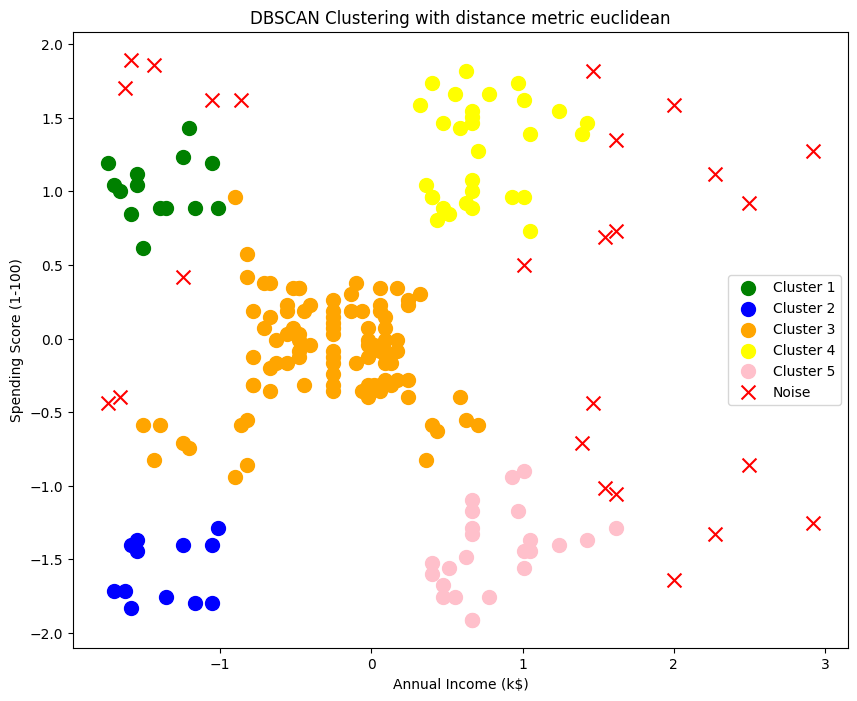

In [17]:
# Define colors for each cluster
cluster_colors = ['green', 'blue', 'orange', 'yellow', 'pink']

# Define markers for noise points
noise_marker = 'x'

# Visualize the clusters
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(standard_matrix[clusters1 == i, 0], standard_matrix[clusters1 == i, 1], s=100, label=f'Cluster {i+1}', color=cluster_colors[i])
plt.scatter(standard_matrix[clusters1 == -1, 0], standard_matrix[clusters1 == -1, 1], s=100, c='red', marker=noise_marker, label='Noise')
plt.title('DBSCAN Clustering with distance metric euclidean')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

### Clusters Properties

- Homogeneity Score: This metric measures how much each cluster contains only samples from a single class. A value of 1.0 indicates that each cluster contains only samples from a single class, making the data split consistent with the known truth labels.

- Completeness Score: This metric measures how much all samples from a single class are assigned to the same cluster. A value of 1.0 indicates that all samples from a single class are assigned to the same cluster, maintaining complete information from the known truth labels.

- V-measure Score: This metric is the harmonic mean between homogeneity and completeness. It provides a comprehensive measure of the alignment between clusters and the known truth labels. A value of 1.0 indicates that clusters perfectly match the known truth labels.

- **Silhouette Score**: This metric measures how similar samples within a cluster are to each other versus how dissimilar they are to samples in neighboring clusters. Values ​​can range from -1 to 1, with higher values ​​indicating better separation of clusters.

In [18]:
# Compute cluster metrics
homogeneity1 = metrics.homogeneity_score(df['Cluster_Standard'], labels)
completeness1 = metrics.completeness_score(df['Cluster_Standard'], labels)
v_measure1 = metrics.v_measure_score(df['Cluster_Standard'], labels)
silhouette1 = metrics.silhouette_score(standard_matrix, labels)

# Print cluster metrics
print("Homogeneity: ", homogeneity1)
print("Completeness: ", completeness1)
print("V-measure: ", v_measure1)
print("Silhouette Score: ", silhouette1)

Homogeneity:  1.0
Completeness:  1.0
V-measure:  1.0
Silhouette Score:  0.4148124800517594


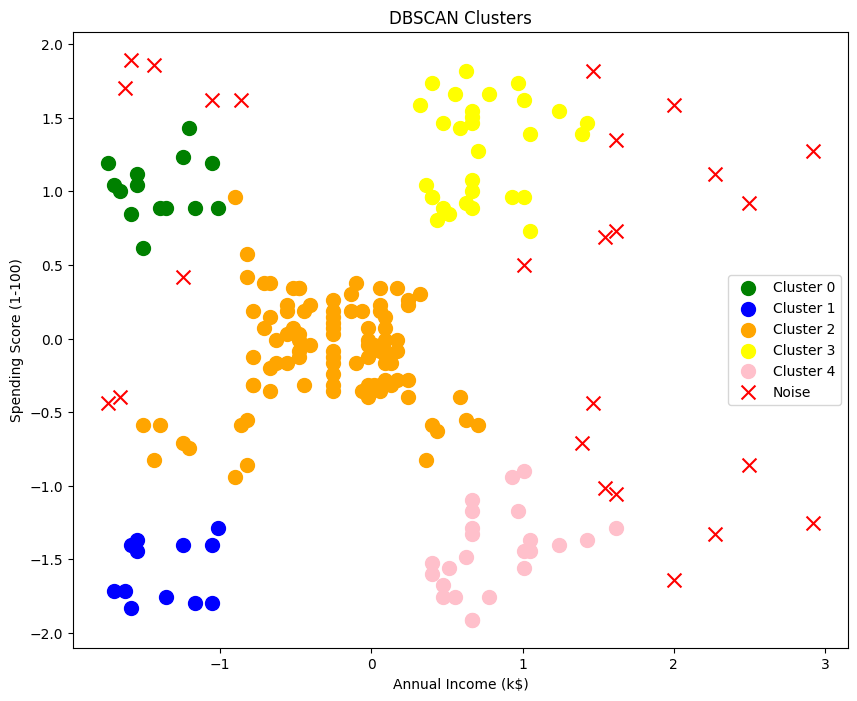

In [19]:
# Define colors for each cluster
cluster_colors = ['green', 'blue', 'orange', 'yellow', 'pink']

# Define markers for noise points
noise_marker = 'x'

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(standard_matrix[clusters1 == i, 0], standard_matrix[clusters1 == i, 1], s=100, label=f'Cluster {i}', color=cluster_colors[i])
plt.scatter(standard_matrix[clusters1 == -1, 0], standard_matrix[clusters1 == -1, 1], s=100, c='red', marker=noise_marker, label='Noise')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('DBSCAN Clusters')
plt.legend()
plt.show()

### Davies-Bouldin Index

The **Davies-Bouldin Index** measures the "feasibility" of clusters, considering both the average distance between cluster points and the distance between cluster centroids. The lower the value, the better the clusters.

In [21]:
# Calcola la matrice delle distanze
distance_matrix = pairwise_distances(standard_matrix, metric='euclidean')

# Calcola l'indice di Davies-Bouldin
davies_bouldin_index1 = davies_bouldin_score(standard_matrix, clusters1)

print("Davies-Bouldin Index:", davies_bouldin_index1)

Davies-Bouldin Index: 1.651289505943405


A Davies-Bouldin Index (DBI) value of 1.6 is generally considered a good value. DBI ranges from 0 to a theoretically infinite value. Lower values ​​indicate more compact and well-separated clusters, which is a desirable goal for a clustering algorithm.

### Calinski-Harabasz Index

The **Calinski-Harabasz** index calculates the ratio of the within-cluster variance to the between-cluster variance. Higher values ​​indicate better clusters.

In [22]:
# Calcola il Calinski-Harabasz Index
calinski_score1 = calinski_harabasz_score(standard_matrix, clusters1)

print("Calinski-Harabasz Index:", calinski_score1)

Calinski-Harabasz Index: 69.14853236059615
